In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os
import numpy as np
import glob2 as glob



# Downloading Data and creating Dataloader

In [2]:
#transforms
transform = transforms.Compose([transforms.ToTensor()])

# Downloading Dataset MNIST and DataLoader
mnist_data = datasets.MNIST('./data', train=True, download=False, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)


# Analysing Dataset

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
# 
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# MODEL
### Linear AutoEncoder Model: 

In [4]:
class Linear_encoder(nn.Module):
    def __init__(self):
        super(Linear_encoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Linear(28 * 28, 128),    # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),         # N, 128 -> N, 64
            nn.ReLU(),
            nn.Linear(64, 12),          # N, 64  -> N, 12
            nn.ReLU(),
            nn.Linear(12, 3)            # N, 12  -> N, 3
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),          
            nn.ReLU(),
            nn.Linear(64, 128),         
            nn.ReLU(),
            nn.Linear(128, 28 * 28),    
            nn.Sigmoid()                # N, 3   -> N, 784
            # compress to a range (0, 1) 
            # # Sigmoid function is used to convert linear values to probabilities
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Convolutional AutoEncoder Model:

In [5]:
class Cnn_encoder(nn.Module):
    def __init__(self):
        super(Cnn_encoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Defining Hyperparameters

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
linear_encoder = Linear_encoder().cuda(device)
cnn_encoder = Cnn_encoder().cuda(device)

# Loss and optimizer
criterion = nn.MSELoss()
linear_optim = torch.optim.Adam(linear_encoder.parameters(), lr=0.001, weight_decay=1e-5)
cnn_optim = torch.optim.Adam(cnn_encoder.parameters(), lr=0.001, weight_decay=1e-5)

# Training
### Training Function:

In [7]:
def training(num_epoch, model, optimizer, criterion, data_loader):
    outputs = []
    for epoch in range(num_epoch):
        for batch_idx, (image, _) in enumerate(data_loader):
            if model.__class__.__name__ == 'Linear_encoder':
                image = image.reshape(-1, 28*28).cuda(device)
            elif model.__class__.__name__ == 'Cnn_encoder':
                image = image.cuda(device)
            # ===================forward=====================
            generated_img = model(image)
            loss = criterion(generated_img, image)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'Epoch: {epoch+1}, loss:{loss.item():.4f}')
        outputs.append((epoch, image, generated_img))
    return outputs

### Actual Training:

In [8]:
num_epoch = 1000
print("======================= LINEAR =======================")
linear_output = training(num_epoch, linear_encoder, linear_optim, criterion, data_loader)
print("======================== CNN =========================")
cnn_output = training(num_epoch, cnn_encoder, cnn_optim, criterion, data_loader)

======================= LINEAR =======================
Epoch: 1, loss:0.0457
Epoch: 2, loss:0.0404
Epoch: 3, loss:0.0339
Epoch: 4, loss:0.0401
Epoch: 5, loss:0.0348
Epoch: 6, loss:0.0399
Epoch: 7, loss:0.0416
Epoch: 8, loss:0.0367
Epoch: 9, loss:0.0412
Epoch: 10, loss:0.0377
Epoch: 11, loss:0.0328
Epoch: 12, loss:0.0320
Epoch: 13, loss:0.0304
Epoch: 14, loss:0.0373
Epoch: 15, loss:0.0327
Epoch: 16, loss:0.0355
Epoch: 17, loss:0.0319
Epoch: 18, loss:0.0332
Epoch: 19, loss:0.0358
Epoch: 20, loss:0.0293
Epoch: 21, loss:0.0310
Epoch: 22, loss:0.0352
Epoch: 23, loss:0.0336
Epoch: 24, loss:0.0331
Epoch: 25, loss:0.0326
Epoch: 26, loss:0.0299
Epoch: 27, loss:0.0315
Epoch: 28, loss:0.0317
Epoch: 29, loss:0.0342
Epoch: 30, loss:0.0326
Epoch: 31, loss:0.0268
Epoch: 32, loss:0.0329
Epoch: 33, loss:0.0337
Epoch: 34, loss:0.0334
Epoch: 35, loss:0.0299
Epoch: 36, loss:0.0374
Epoch: 37, loss:0.0389
Epoch: 38, loss:0.0338
Epoch: 39, loss:0.0235
Epoch: 40, loss:0.0289
Epoch: 41, loss:0.0282
Epoch: 42, 

# Visualizing Results

In [9]:
# clearing results folder
for f in glob.glob('results/*'): os.remove(f)

In [10]:
def plot_results(flag, outputs, num_epochs, interval):
    for k in range(0, num_epochs, interval):
        plt.figure(figsize=(9, 2))
        plt.gray()
        imgs = outputs[k][1].detach().cpu().numpy()
        recon = outputs[k][2].detach().cpu().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i + 1)
            item = item.reshape(-1, 28, 28)
            plt.imshow(item[0])
        
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9 + i + 1)
            item = item.reshape(-1, 28, 28)
            plt.imshow(item[0])
    
        plt.savefig(f'results/{flag}_epoch_set_{k}.png')
    return None

======================= LINEAR =======================


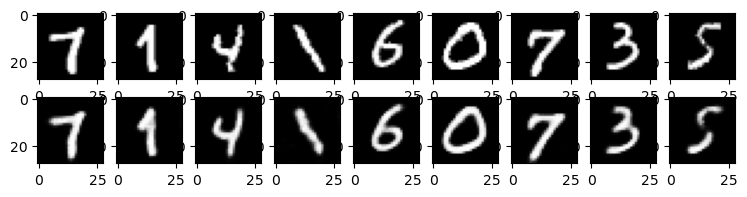

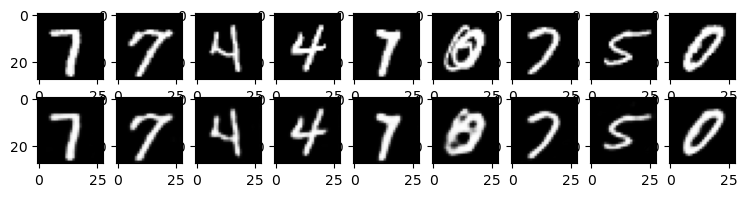

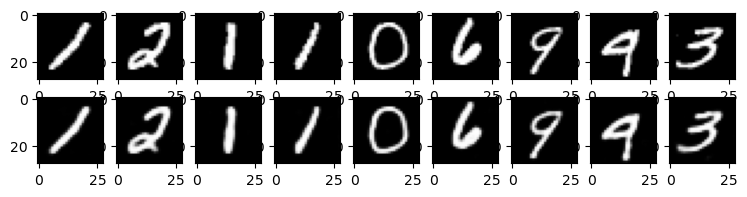

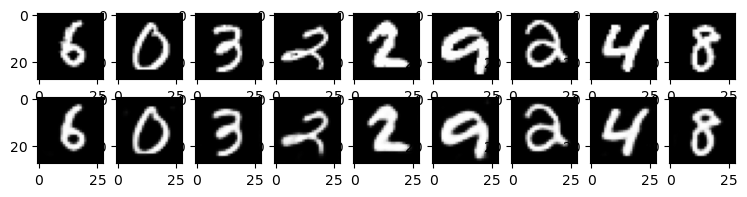

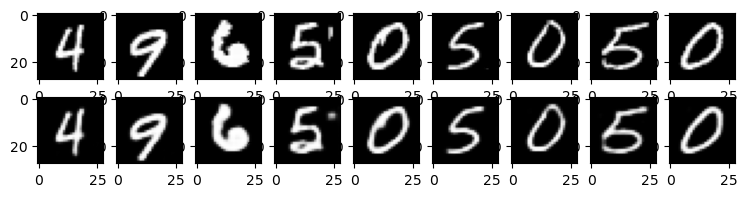

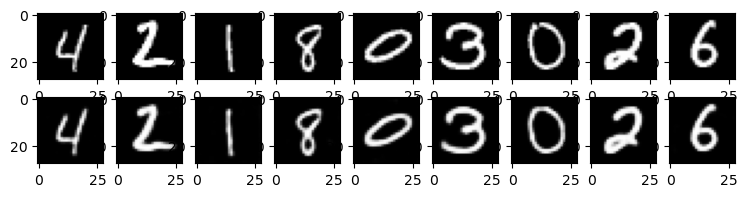

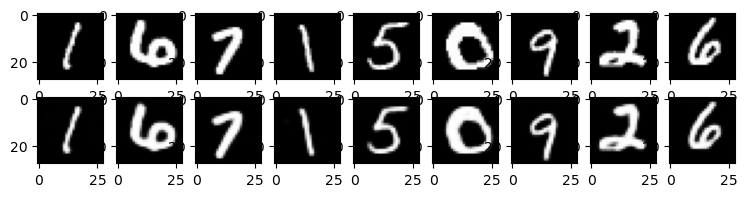

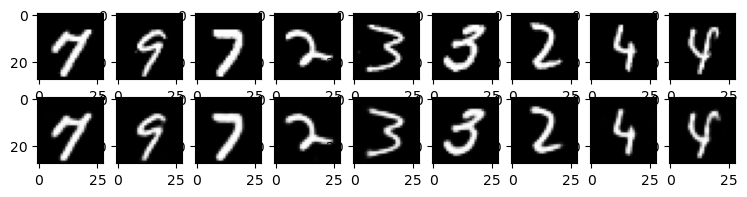

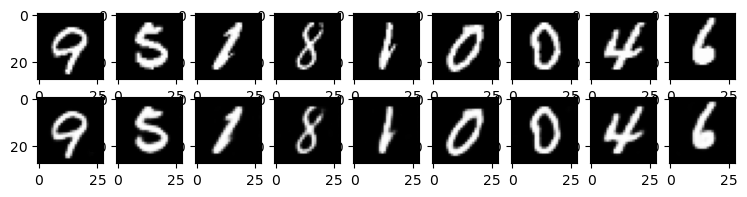

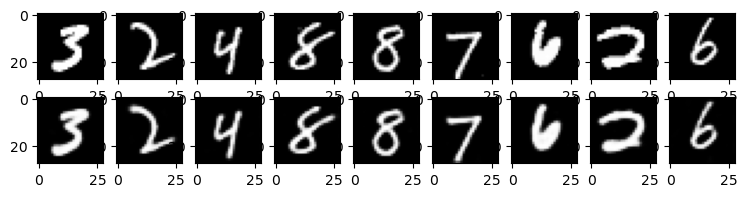

In [11]:
print("======================= LINEAR =======================")
plot_results('linear', cnn_output, num_epoch, 100)

======================= CNN =======================


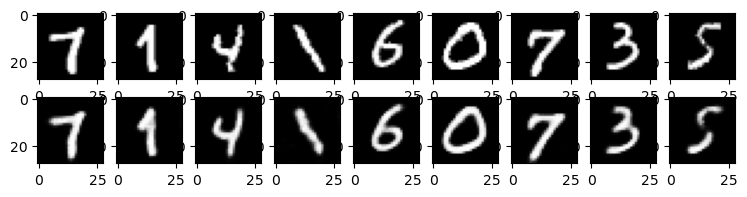

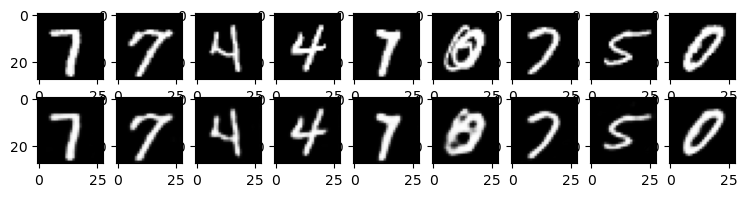

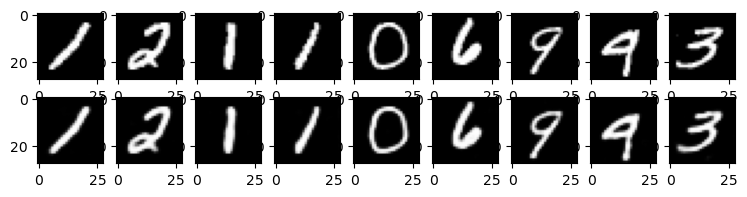

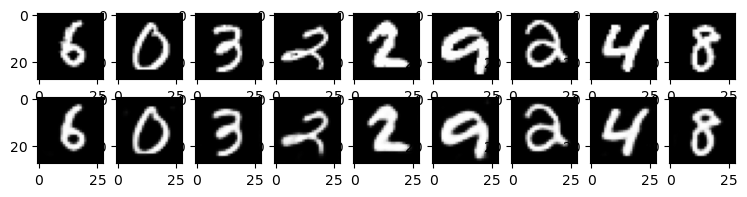

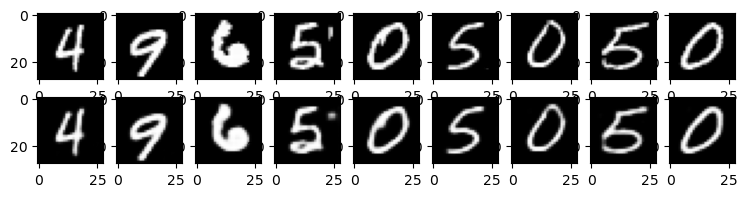

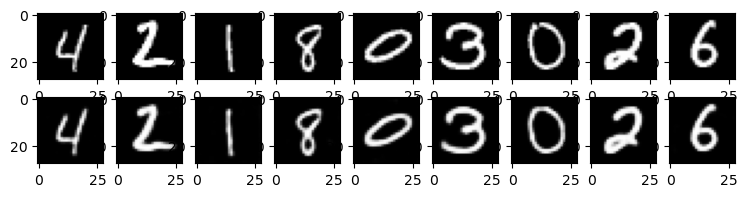

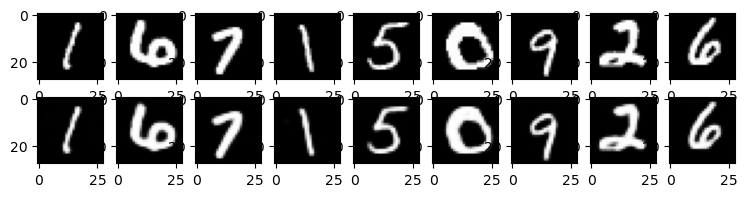

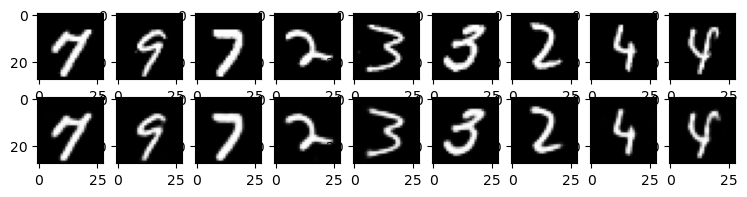

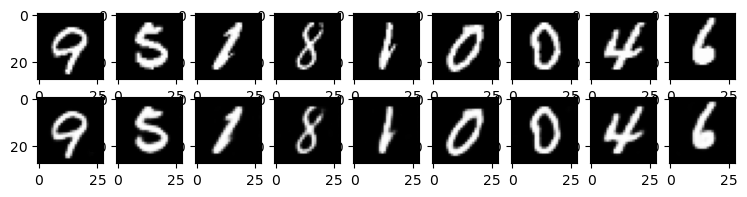

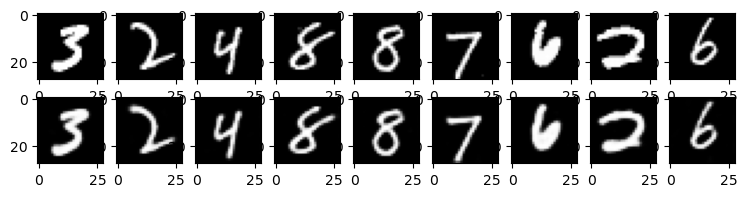

In [12]:
print("======================= CNN =======================")
plot_results('cnn', cnn_output, num_epoch, 100)

In [32]:
plt.close()

# Saving the models to pth files

In [13]:
torch.save(linear_encoder.state_dict(), 'linear_encoder.pth')
torch.save(cnn_encoder.state_dict(), 'cnn_encoder.pth')

# Inferencing the Model

In [66]:
def inferencing(inference_image, inference_model, title):
    """
    This function is used plot the inference results
    ------------------------------------------------
    Inputs:
    inference_image: the image to be inferred Linear:(-1, 784) & CNN:(-1, 28, 28)
    inference_model: (linear_inference_model or cnn_inference_model)
    title: the title of the plot
    
    Output:
    None
    """
    while True:
        plt.figure(figsize=(10, 5))
        plt.gray()
        for i in range(50):
            plt.subplot(5, 10, i + 1)
            with torch.no_grad():
                output_img = inference_model(inference_image)
                inference_image = output_img
                output_img = output_img.detach().cpu().numpy()
                plt.imshow(output_img.reshape(-1, 28, 28)[0])
        plt.suptitle(title)
        plt.show()
        break
    return None

## Linear AutoEncoder Inference

Text(0.5, 1.0, 'Random Image: ')

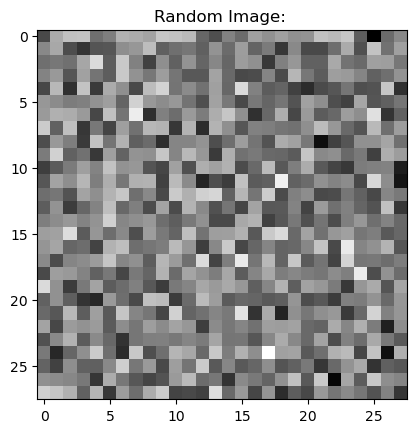

In [91]:
# Load inference models
linear_inference_model = Linear_encoder().cuda(device)
cnn_inference_model = Cnn_encoder().cuda(device)

# Loading weights
linear_inference_model.load_state_dict(torch.load('linear_encoder.pth'))
cnn_inference_model.load_state_dict(torch.load('cnn_encoder.pth'))

# Setting to evaluation mode
linear_inference_model.eval()
cnn_inference_model.eval()

# Creating Random image for inference
inference_image = torch.randn(28, 28, 1).cuda(device)
plt.imshow(inference_image.detach().cpu().numpy())
plt.title("Random Image: ")

Text(0.5, 1.0, 'First Linear Inference: ')

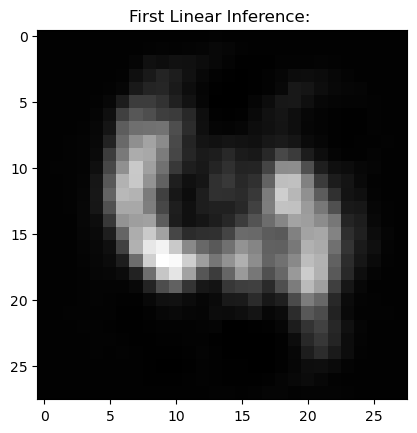

In [92]:
aaa = linear_inference_model(inference_image.reshape(-1, 28*28))
plt.imshow(aaa.detach().cpu().numpy().reshape(-1, 28, 28)[0])
plt.title("First Linear Inference: ")
                        

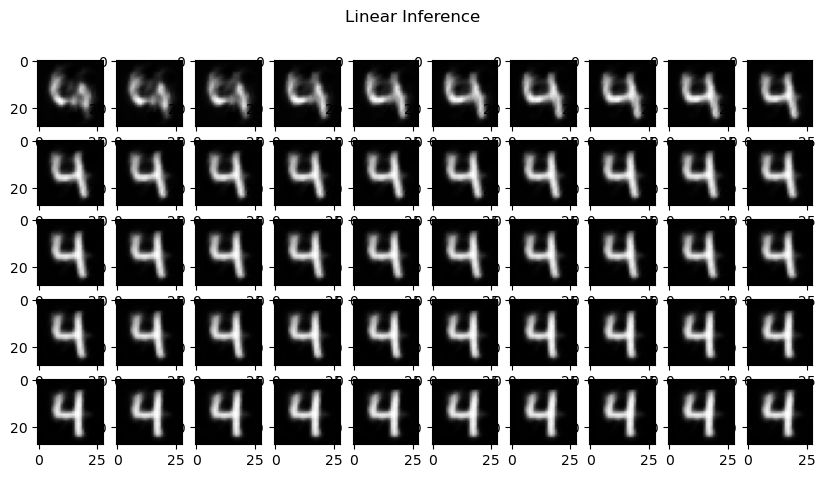

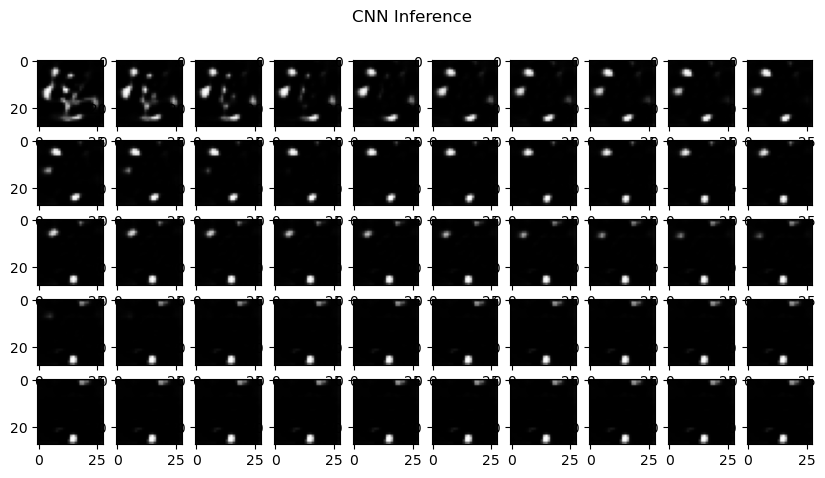

In [93]:
# Inferencing over and over again withing same generated image
# INFERENCING
inferencing(inference_image.permute(2,0,1).reshape(-1, 28*28), linear_inference_model, "Linear Inference")
inferencing(inference_image.permute(2,0,1), cnn_inference_model, "CNN Inference")